<a href="https://colab.research.google.com/github/Antoine-Cohen/PI2_Hearme/blob/Machine-Learning-models/Classification_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_io

In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
testing_wav_file_name = tf.keras.utils.get_file('cough.wav',
                                                'https://storage.googleapis.com/audioset/yamalyzer/audio/cough.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

409600/395088 [===============================] - 0s 0us/step
./test_data/cough.wav


In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

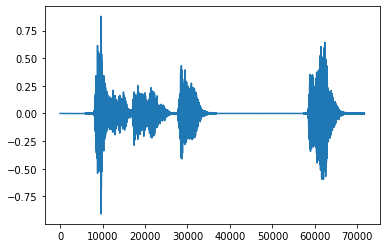

In [ ]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Alarm
The embeddings shape: (24, 1024)


In [ ]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [ ]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:

cat_list = ['dog','cat','vacuum_cleaner','thunderstorm','washing-machine','car_horn','alarm_clock','train','airplane','coughing']
map_class_to_id = dict(zip(cat_list,np.arange(0,len(cat_list),1)))
filtered_pd = pd_data[pd_data.category.isin(cat_list)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
2,./datasets/ESC-50-master/audio/1-100210-A-36.wav,1,2,vacuum_cleaner,False,100210,A
3,./datasets/ESC-50-master/audio/1-100210-B-36.wav,1,2,vacuum_cleaner,False,100210,B
4,./datasets/ESC-50-master/audio/1-101296-A-19.wav,1,3,thunderstorm,False,101296,A
5,./datasets/ESC-50-master/audio/1-101296-B-19.wav,1,3,thunderstorm,False,101296,B
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
16,./datasets/ESC-50-master/audio/1-115521-A-19.wav,1,3,thunderstorm,False,115521,A
25,./datasets/ESC-50-master/audio/1-11687-A-47.wav,1,8,airplane,False,11687,A
28,./datasets/ESC-50-master/audio/1-119125-A-45.wav,1,7,train,False,119125,A
53,./datasets/ESC-50-master/audio/1-17124-A-43.wav,1,5,car_horn,False,17124,A


In [ ]:
filtered_pd.shape

(320, 7)

In [ ]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(cat_list))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 529,930
Trainable params: 529,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
60/60 [==============================] - 26s 300ms/step - loss: 1.0793 - accuracy: 0.7490 - val_loss: 0.6201 - val_accuracy: 0.8047
Epoch 2/20
60/60 [==============================] - 1s 10ms/step - loss: 0.5435 - accuracy: 0.8286 - val_loss: 0.4659 - val_accuracy: 0.8328
Epoch 3/20
60/60 [==============================] - 1s 10ms/step - loss: 0.4400 - accuracy: 0.8589 - val_loss: 0.5252 - val_accuracy: 0.8438
Epoch 4/20
60/60 [==============================] - 1s 10ms/step - loss: 0.3731 - accuracy: 0.8693 - val_loss: 0.4970 - val_accuracy: 0.8422
Epoch 5/20
60/60 [==============================] - 1s 10ms/step - loss: 0.3886 - accuracy: 0.8844 - val_loss: 0.4708 - val_accuracy: 0.8328
Epoch 6/20
60/60 [==============================] - 1s 10ms/step - loss: 0.3673 - accuracy: 0.8891 - val_loss: 0.5347 - val_accuracy: 0.8141
Epoch 7/20
60/60 [==============================] - 1s 10ms/step - loss: 0.2721 - accuracy: 0.9010 - val_loss: 0.5545 - val_accuracy: 0.8344
Epoch 8/20


In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

20/20 [==============================] - 0s 5ms/step - loss: 0.9787 - accuracy: 0.7734
Loss:  0.9787269830703735
Accuracy:  0.7734375


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()
inferred_class = cat_list[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: coughing


In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


In [ ]:
saved_model_path = './audio_classification_model'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)


INFO:tensorflow:Assets written to: ./audio_classification_model/assets


INFO:tensorflow:Assets written to: ./audio_classification_model/assets


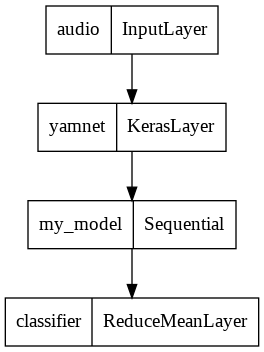

In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
class_pred = cat_list[tf.argmax(reloaded_results)]
print(f'The main sound is: {class_pred}')

The main sound is: coughing


In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
class_pred = cat_list[tf.argmax(serving_results['classifier'])]
print(f'The main sound is: {class_pred}')

The main sound is: coughing


./datasets/ESC-50-master/audio/5-215449-A-47.wav


Waveform values: [ 2.0277384e-06 -5.6266836e-06  1.5815872e-06 ... -9.7116071e-04
 -5.4985965e-03 -5.8065746e-03]


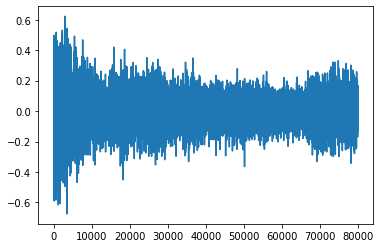

In [ ]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [ ]:
test_pd

,filename,fold,target,category,esc10,src_file,take
1623,./datasets/ESC-50-master/audio/5-156999-A-19.wav,5,3,thunderstorm,False,156999,A
1624,./datasets/ESC-50-master/audio/5-156999-B-19.wav,5,3,thunderstorm,False,156999,B
1625,./datasets/ESC-50-master/audio/5-156999-C-19.wav,5,3,thunderstorm,False,156999,C
1626,./datasets/ESC-50-master/audio/5-156999-D-19.wav,5,3,thunderstorm,False,156999,D
1627,./datasets/ESC-50-master/audio/5-156999-E-19.wav,5,3,thunderstorm,False,156999,E
...,...,...,...,...,...,...,...
1953,./datasets/ESC-50-master/audio/5-251971-A-47.wav,5,8,airplane,False,251971,A
1968,./datasets/ESC-50-master/audio/5-256452-A-5.wav,5,1,cat,False,256452,A
1973,./datasets/ESC-50-master/audio/5-259169-A-5.wav,5,1,cat,False,259169,A
1996,./datasets/ESC-50-master/audio/5-263902-A-36.wav,5,2,vacuum_cleaner,False,263902,A


In [ ]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_inferred_class = cat_list[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Artillery fire (0.15188559889793396)
[Your model] The main sound is: thunderstorm (0.9974179267883301)
